# Simulation on:
### Grouped Patterns of Heterogeneity in Panel Data, Bonhomme, S. and Manresa, E. (2015)

In [1]:
# %matplotlib notebook 
# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 4]

os.chdir(r"GFE_generic")

Initialize a dataset with 10 individual units divided into 3 grous spanning 20 periods. Assigning group membership randomly using unifrom distribution. In addition, choosing time trend (drift term) for the groups. 

In [2]:
np.random.seed(seed=10) # used in random group assignment

nt = 20 # number of periods
nc = 10 # number of units/countries
ng = 3  # number of groups

gtrend = np.random.randint(-10,10,ng) # create integer trend within [-10;10] for each group

gtresh = np.linspace(0,1,ng+1)[:-1]   # linear treshold to randomly divide into groups
group_place = np.random.random(nc)    # assign uniform RN to each unit for dividing into groups
cg = [np.argmin(i>gtresh)+1 for i in group_place] # where the assigned RN are located in grid of thresholds

print(f'Thresholds for group assignment: {gtresh}')
print(f'Trends for each group: {gtrend}')
print(f'Assigned groups: {cg}')

Thresholds for group assignment: [0.         0.33333333 0.66666667]
Trends for each group: [-1 -6  5]
Assigned groups: [3, 1, 3, 2, 2, 1, 2, 2, 1, 1]


# Creating trends

Random trend with drift term. Random trend shock has mean 0 and standard deviation of 25. 

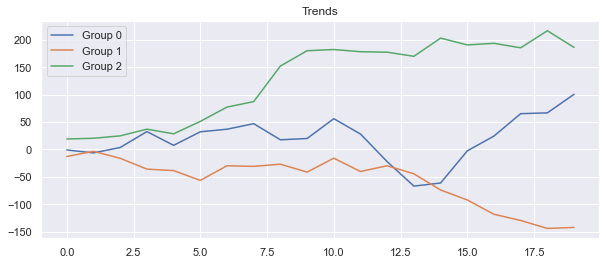

In [3]:
# Trends for groups
groups = {}
for i in range(ng):
    ds = [0]
    for y in range(nt):
        ds.append(ds[-1]+gtrend[i]+np.random.normal(scale=25)) # drift, normal random disturbances with std=25
        
    groups['g'+str(i+1)+'t'] = ds[1:] # group i's trend
    plt.plot(groups['g'+str(i+1)+'t'], label='Group ' + str(i))

plt.title('Trends')
plt.legend()

# Create panel data based on groups, group trends, covariates and noise

Since the trend is known for each group and group assignment is known, now generate individual series by adding noises to the trend and covariates. For covariates and corresponding parameters, here I am using arbitrary numbers. However, note that the coefficients of the covariates are fixed over groups and individual (time varying covariates effect was mentioned in the paper as an extension).

In [4]:
Group_trend = []
time = []
individual = []
i_group = []
coef_X1 = 15
coef_X2 = 5
std_u = 10

for i, group in enumerate(cg):
    obs = groups['g'+str(group)+'t']
    Group_trend.extend(obs)
    time.extend(np.arange(nt))
    individual.extend(np.full(nt,i))
    i_group.extend(np.full(nt,group))
    
df               = pd.DataFrame()
df['X1']         = np.random.rand(len(Group_trend))
df['X2']         = np.random.rand(len(Group_trend))
df['Group_trend']= Group_trend
df['u']          = std_u*np.random.randn(len(Group_trend))
df['Y']          = df['Group_trend'] + coef_X1*df['X1']  + coef_X2*df['X2'] + df['u']
df['time']       = time
df['individual'] = individual
df['group']      = i_group

In [5]:
df

,X1,X2,Group_trend,u,Y,time,individual,group
0,0.346347,0.113960,19.128817,5.042715,29.936540,0,0,3
1,0.043097,0.372029,20.443310,8.042674,30.992589,1,0,3
2,0.879915,0.766560,24.795677,-10.306082,31.521123,2,0,3
3,0.763241,0.321142,37.023032,-13.576976,36.500375,3,0,3
4,0.878097,0.638035,28.526055,-2.665019,42.222662,4,0,3
...,...,...,...,...,...,...,...,...
195,0.827903,0.937849,-2.601634,-5.901865,8.604295,15,9,1
196,0.963901,0.769012,24.490647,-28.160012,14.634204,16,9,1
197,0.598936,0.884719,65.306203,1.095444,79.809287,17,9,1
198,0.930916,0.871005,66.784933,1.426693,86.530388,18,9,1


Text(0.5, 1.0, 'Time series (individual units)')

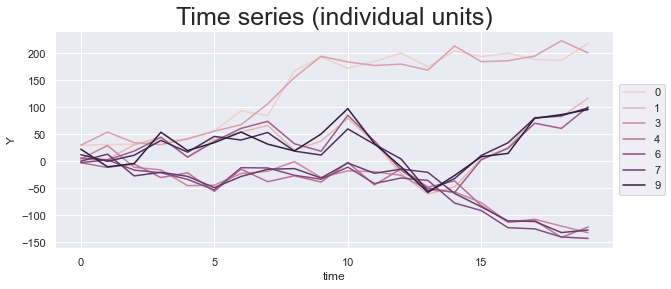

In [14]:
# Visualize by individuals
sns.lineplot(data=df,x='time',y='Y',hue='individual')
plt.xticks(np.arange(0, nt, step=5))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Time series (individual units)",fontsize=25)

Text(0.5, 1.0, 'Time series (groups (with bands))')

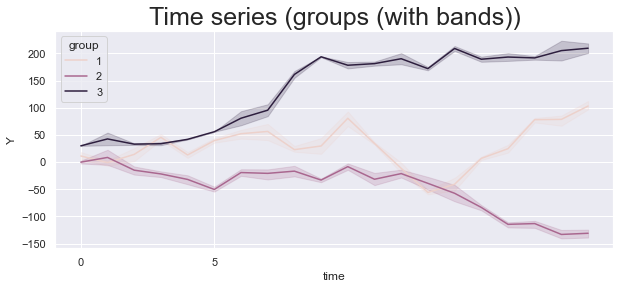

In [15]:
# Visualize by groups
sns.lineplot(data=df,x='time',y='Y',hue='group')
plt.xticks(np.arange(0, nc, step=5))
plt.title("Time series (groups (with bands))",fontsize=25)

# Export to STATA to process it with the author's toolbox

In [8]:
df.to_stata(r'df.dta')

# Running authors' the toolbox

* Put data file (df.dta in our case), Bootstrap_version.exe and GFE_code.do files in the same directory. 
* Configure GFE_code.do. Adjust USER INPUTS. 
* Then run GFE_code, also fill in the prompted inputs.
* DATA_GFE.dta will be generated in the same folder. This data file contains group information. 


When running GFE_code.do, choose the following parameters:

* Adjust the data directory path in line 87.
* Number of groups: type “4” if number of groups is 4. 
* Number of covariates: type “2” if number of covariates is 2.
* Algorithm: type “1” (for Algorithm 2).
* Number of simulations: type “10”.
* Number of neighbors: type “10”
* Number of steps: type “10”.
* Standard errors: type “1” (for bootstrapped standard errors).
* Algorithm: type “1” (for Algorithm 2).
* Number of simulations: type “5”.
* Number of neighbors: type “10”.
* Number of steps: type “5”.
* Number of bootstrap replications: type “100”.

# Results

Import 'DATA_GFE.dta', the output of the toolbox which has an additional column with group information on top of the original data. 

In [9]:
# Estimated groups
df_gfe = pd.read_stata(r'DATA_GFE.dta')
df_gfe.groupby('individual').agg({'assignment':['mean','max','min']})


assignment        
                 mean max min
individual                   
0                   3   3   3
1                   1   1   1
2                   3   3   3
3                   2   2   2
4                   2   2   2
5                   1   1   1
6                   2   2   2
7                   2   2   2
8                   1   1   1
9                   1   1   1

Compare if the group assigned by the estimator to the actual group memberships.

In [10]:
print('Assigned groups: {}'.format(cg))

est_g = df_gfe.groupby('individual')['assignment'].agg('mean').to_list()
print('Estimated groups: {}'.format(est_g))

assert cg == est_g, "Mismatch in groups"

Assigned groups: [3, 1, 3, 2, 2, 1, 2, 2, 1, 1]
Estimated groups: [3, 1, 3, 2, 2, 1, 2, 2, 1, 1]


# The end of simulation